Rong Wang rongwww 1619779944

<b>1. Multi-class and Multi-Label Classification Using Support Vector Machines</b>

(a) Download the Anuran Calls (MFCCs) Data Set from: https://archive.ics.uci.edu/ml/datasets/Anuran+Calls+%28MFCCs%29. Choose 70% of the data randomly as the training set.

In [71]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import hamming_loss, accuracy_score, silhouette_score
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import hamming
import math
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore') # category=ConvergenceWarning

In [39]:
# Reference: https://www.activestate.com/resources/quick-reads/how-to-slice-a-dataframe-in-pandas/
# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
dataset = pd.read_csv("../data/Anuran Calls (MFCCs)/Frogs_MFCCs.csv")
X = dataset.iloc[:, :22]
y = dataset.iloc[:, 22:-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_test, y_train, y_test

(      MFCCs_ 1  MFCCs_ 2  MFCCs_ 3  MFCCs_ 4  MFCCs_ 5  MFCCs_ 6  MFCCs_ 7  \
 2004  1.000000  0.327476  0.282440  0.572211  0.096509 -0.036705 -0.082174   
 1194  1.000000  0.232818 -0.144331 -0.078909 -0.072467  0.255380  0.450215   
 5359  0.966443  0.455914  1.000000  0.541650 -0.412873  0.307099  0.235819   
 1756  1.000000  0.257873  0.112807  0.527614  0.186094  0.043683 -0.163682   
 497   1.000000  0.401859  0.563219  0.578304 -0.126517 -0.058725  0.431806   
 ...        ...       ...       ...       ...       ...       ...       ...   
 3772  1.000000  0.406366  0.268684  0.704863  0.358415  0.055376 -0.159812   
 5191  1.000000  0.634337  0.594395  0.403271  0.004960  0.037880 -0.065399   
 5226  1.000000  0.756413  0.732319  0.385807 -0.034821  0.073881 -0.058027   
 5390  0.931410  0.626137  1.000000  0.375834 -0.223044  0.325943  0.121659   
 860   1.000000  0.332793 -0.056006  0.358653  0.508890  0.185081 -0.205522   
 
       MFCCs_ 8  MFCCs_ 9  MFCCs_10  ...  MFCCs_13

(b) Each instance has three labels: Families, Genus, and Species. Each of the labels has multiple classes. We wish to solve a multi-class and multi-label problem. One of the most important approaches to multi-label classification is to train a classifier for each label (binary relevance). We first try this approach:

i. Research exact match and hamming score/ loss methods for evaluating multi-label classification and use them in evaluating the classifiers in this problem.

Reference: 
https://medium.datadriveninvestor.com/a-survey-of-evaluation-metrics-for-multilabel-classification-bb16e8cd41cd
https://peltarion.com/knowledge-center/documentation/evaluation-view/classification-loss-metrics/exact-match-ratio
https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/HammingLoss#:~:text=Hamming%20loss%20is%20the%20fraction,penalizes%20only%20the%20individual%20labels.

Exact match: a very strict measure of the model performance. It increases only when the model correctly identifies every possible label that an example has, without any false positive.

Hamming Score/Loss: the proportion of incorrectly predicted labels to the total number of labels. Score = 1-Loss.

ii. Train a SVM for each of the labels, using Gaussian kernels and one versus all classifiers. Determine the weight of the SVM penalty and the width of the Gaussian Kernel using 10 fold cross validation.1 You are welcome to try to solve the problem with both standardized 2 and raw attributes and report the results.

1. How to choose parameter ranges for SVMs? One can use wide ranges for the parameters and a fine grid (e.g. 1000 points) for cross validation; however,this method may be computationally expensive. An alternative way is to train the SVM with very large and very small parameters on the whole training data and find very large and very small parameters for which the training accuracy is not below a threshold (e.g., 70%). Then one can select a fixed number of parameters (e.g., 20) between those points for cross validation. For the penalty parameter, usually one has to consider increments in log(λ). For example, if one found that the accuracy of a support vector machine will not be below 70% for λ = 10−3 and λ = 106, one has to choose log(λ) ∈ {−3,−2,...,4,5,6}. For the Gaussian Kernel parameter, one usually chooses linear increments, e.g. σ ∈ {.1, .2, . . . , 2}. When both σ and λ are to be chosen using cross-validation, combinations of very small and very large λ’s and σ’s that keep the accuracy above a threshold (e.g.70%) can be used to determine the ranges for σ and λ. Please note that these are very rough rules of thumb, not general procedures.

2. It seems that the data are already normalized.

In [15]:
y_train_family = y_train["Family"]
y_train_genus = y_train["Genus"]
y_train_species = y_train["Species"]
y_test_family = y_test["Family"]
y_test_genus = y_test["Genus"]
y_test_species = y_test["Species"]

In [43]:
# Reference: 
# https://scikit-learn.org/stable/modules/svm.html
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html
# https://medium.com/@saugata.paul1010/a-detailed-case-study-on-multi-label-classification-with-machine-learning-algorithms-and-72031742c9aa
# https://www.tandfonline.com/doi/full/10.1080/17415977.2020.1797716

# Gaussian kernels and one versus all classifiers.
# Gaussian Kernel is also called RBF(Radial Basis Function) kernel.
rbf_svc = SVC(kernel='rbf', decision_function_shape='ovo')  
# rbf_svc.kernel #'rbf'

# Consider two parameters: C and gamma.
# cRange = [10**c for c in np.arange(-5,5, dtype=float)]
# gammaRange = np.arange(0.1, 2.1, 0.1)
cRange = np.logspace(-1, 3, 5)  # the third parameter in that function can be used to somewhat speedup the process
gammaRange = np.linspace(0.1, 2, 5)

parameters = {'C':cRange, 'gamma':gammaRange}

def b_ii(y_train):
    clf = GridSearchCV(rbf_svc, parameters, cv=10, n_jobs=-1) # max_iter = 1000 cause warnings
    clf.fit(X_train, y_train)
    c, gamma = clf.best_params_['C'], clf.best_params_['gamma']
    print("best c: {}, best gamma: {}".format(c, gamma))
    
    svc = SVC(kernel='rbf', decision_function_shape='ovo', max_iter = 1000, C=c, gamma=gamma).fit(X_train, y_train)
    y_pred = pd.DataFrame(svc.predict(X_test))
    return y_pred

y_pred = []
for y in [y_train_family, y_train_genus, y_train_species]:
    y_pred.append(b_ii(y))
    # This is a multi-label classification problem. 
    # Combine the predicted labels together to calculate the hamming loss and exact match.
y_pred_total = pd.concat(y_pred, axis=1)

print("Hamming Loss for Family: ", hamming_loss(y_test["Family"], y_pred[0]))
print("Hamming Loss for Genus: ", hamming_loss(y_test["Genus"], y_pred[1]))
print("Hamming Loss for Species: ", hamming_loss(y_test["Species"], y_pred[2]))
# y_pred_family = b_ii(y_train_family)
# y_pred_genus = b_ii(y_train_genus)
# y_pred_species = b_ii(y_train_species)
# y_pred_total = pd.concat([y_pred_family.rename('Family'), y_pred_genus.rename('Genus'), y_pred_species.rename('Species')], axis=1)

# print(y_pred_total)
def countScore(yPredict, yTrue):
    num_instance = yPredict.shape[0]
    total_instance = num_instance * yPredict.shape[1] # *3
    hamming_correct = 0
    exact_correct = 0
    for i, r in enumerate(yPredict.iterrows()):
        if yPredict.iloc[i].tolist() == yTrue.iloc[i].tolist():
            exact_correct += 1
            hamming_correct += yPredict.shape[1]
        else:
            for j in range(yPredict.shape[1]):
                if yPredict.iloc[i].tolist()[j] == yTrue.iloc[i].tolist()[j]:
                    hamming_correct += 1
    return hamming_correct/total_instance, exact_correct/num_instance
hamming_score, exact_match = countScore(y_pred_total, y_test)
# hamming = hamming_loss(y_test, y_pred_total)
# exact_match = accuracy_score(y_test, y_pred_total)

# print(y_pred_total)
# print(y_test)
print("Exact match: ", exact_match)
print("Hamming Score: ", hamming_score)  # Score = 1 - Loss
print("Hamming Loss: ", 1-hamming_score) 

best c: 10.0, best gamma: 2.0
best c: 100.0, best gamma: 1.525
best c: 10.0, best gamma: 2.0
Hamming Loss for Family:  0.006021306160259379
Hamming Loss for Genus:  0.009263547938860583
Hamming Loss for Species:  0.010189902732746642
Exact match:  0.9879573876794813
Hamming Score:  0.9915084143893778
Hamming Loss:  0.008491585610622243


In [44]:
# Reference: 
# https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/#:~:text=Standardizing%20a%20dataset%20involves%20rescaling,value%20or%20centering%20the%20data.
# https://medium.com/analytics-vidhya/why-it-makes-a-difference-how-to-standardize-training-and-test-set-e95bf350bed3
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

# fit StandardScaler on the training dataset and standardize both training data and test data with transform()
scaler = StandardScaler()
scaler.fit(X_train)
X_train_standard = scaler.transform(X_train)
X_test_standard = scaler.transform(X_test)

In [51]:
parameters = {'C':cRange, 'gamma':gammaRange}
def b_ii_standard(y_train):
    clf = GridSearchCV(rbf_svc, parameters, cv=10, n_jobs=-1) # max_iter = 1000 cause warnings
    clf.fit(X_train_standard, y_train)
    c, gamma = clf.best_params_['C'], clf.best_params_['gamma']
    print("best c: {}, best gamma: {}".format(c, gamma))
    
    svc = SVC(kernel='rbf', decision_function_shape='ovo', max_iter = 1000, C=c, gamma=gamma).fit(X_train_standard, y_train)
    y_pred = pd.DataFrame(svc.predict(X_test_standard))
    return y_pred

y_pred = []
for y in [y_train_family, y_train_genus, y_train_species]:
    y_pred.append(b_ii_standard(y))
    # This is a multi-label classification problem. 
    # Combine the predicted labels together to calculate the hamming loss and exact match.
y_pred_total = pd.concat(y_pred, axis=1)

print("Hamming Loss for Family: ", hamming_loss(y_test["Family"], y_pred[0]))
print("Hamming Loss for Genus: ", hamming_loss(y_test["Genus"], y_pred[1]))
print("Hamming Loss for Species: ", hamming_loss(y_test["Species"], y_pred[2]))

hamming_score, exact_match = countScore(y_pred_total, y_test)
print("Exact match: ", exact_match)
print("Hamming Score: ", hamming_score)  # Score = 1 - Loss
print("Hamming Loss: ", 1-hamming_score) 

best c: 10.0, best gamma: 0.1
best c: 10.0, best gamma: 0.1
best c: 10.0, best gamma: 0.1
Hamming Loss for Family:  0.007410838351088467
Hamming Loss for Genus:  0.012042612320518759
Hamming Loss for Species:  0.015748031496062992
Exact match:  0.983788791106994
Hamming Score:  0.9882661726107765
Hamming Loss:  0.011733827389223461


Based on the above results and the train/test set splited randomly, raw data performs better than standardlized data, on both exact match score and Hamming Score.

iii. Repeat 1(b)ii with L1-penalized SVMs.3 Remember to standardize4 the attributes. Determine the weight of the SVM penalty using 10 fold cross validation.

3. The convention is to use L1 penalty with linear kernel. 
4. It seems that the data are already normalized.

In [55]:
parameters = {'C': cRange}
svc_L1 = LinearSVC(penalty='l1', dual=False, max_iter = 10000)

def b_iii_standard(y_train):
    clf = GridSearchCV(svc_L1, parameters, cv=10, n_jobs=-1)
    clf.fit(X_train_standard, y_train)
    c = clf.best_params_['C']
    print("best c: {}".format(c))
    
    svc = LinearSVC(penalty='l1', C=c, dual=False, max_iter = 10000).fit(X_train_standard, y_train)
    y_pred = pd.DataFrame(svc.predict(X_test_standard))
    return y_pred

y_pred = []
for y in [y_train_family, y_train_genus, y_train_species]:
    y_pred.append(b_iii_standard(y))
# This is a multi-label classification problem. 
# Combine the predicted labels together to calculate the hamming loss and exact match.
y_pred_total = pd.concat(y_pred, axis=1)

print("Hamming Loss for Family: ", hamming_loss(y_test["Family"], y_pred[0]))
print("Hamming Loss for Genus: ", hamming_loss(y_test["Genus"], y_pred[1]))
print("Hamming Loss for Species: ", hamming_loss(y_test["Species"], y_pred[2]))

hamming_score, exact_match = countScore(y_pred_total, y_test)
print("Exact match: ", exact_match)
print("Hamming Score: ", hamming_score)  # Score = 1 - Loss
print("Hamming Loss: ", 1-hamming_score) 

best c: 1.0


/Users/aurorawong/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/aurorawong/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/aurorawong/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/aurorawong/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


best c: 10.0


/Users/aurorawong/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/aurorawong/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/aurorawong/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/aurorawong/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


best c: 10.0
Hamming Loss for Family:  0.07132931912922649
Hamming Loss for Genus:  0.058360352014821676
Hamming Loss for Species:  0.04075961093098657
Exact match:  0.9129226493747105
Hamming Score:  0.9431835726416551
Hamming Loss:  0.05681642735834491


iv. Repeat 1(b)iii by using SMOTE or any other method you know to remedy class imbalance. Report your conclusions about the classifiers you trained.

In [62]:
sm = SMOTE()
X_train_family_smote, y_train_family_smote = sm.fit_resample(X_train_standard, y_train_family)
X_train_genus_smote, y_train_genus_smote = sm.fit_resample(X_train_standard, y_train_genus)
X_train_species_smote, y_train_species_smote = sm.fit_resample(X_train_standard, y_train_species)

In [64]:
parameters = {'C': cRange}
svc_L1 = LinearSVC(penalty='l1', dual=False, max_iter = 10000)

def b_iv(x_train, y_train):
    clf = GridSearchCV(svc_L1, parameters, cv=10, n_jobs=-1)
    clf.fit(x_train, y_train)
    c = clf.best_params_['C']
    print("best c: {}".format(c))
    
    svc = LinearSVC(penalty='l1', C=c, dual=False, max_iter = 10000).fit(x_train, y_train)
    y_pred = pd.DataFrame(svc.predict(X_test_standard))
    return y_pred

y_pred = []
for y in [[X_train_family_smote, y_train_family_smote], [X_train_genus_smote, y_train_genus_smote], [X_train_species_smote, y_train_species_smote]]:
    y_pred.append(b_iv(y[0], y[1]))
# This is a multi-label classification problem. 
# Combine the predicted labels together to calculate the hamming loss and exact match.
y_pred_total = pd.concat(y_pred, axis=1)

print("Hamming Loss for Family: ", hamming_loss(y_test["Family"], y_pred[0]))
print("Hamming Loss for Genus: ", hamming_loss(y_test["Genus"], y_pred[1]))
print("Hamming Loss for Species: ", hamming_loss(y_test["Species"], y_pred[2]))

hamming_score, exact_match = countScore(y_pred_total, y_test)
print("Exact match: ", exact_match)
print("Hamming Score: ", hamming_score)  # Score = 1 - Loss
print("Hamming Loss: ", 1-hamming_score) 

best c: 1000.0
best c: 100.0
best c: 100.0
Hamming Loss for Family:  0.0921723019916628
Hamming Loss for Genus:  0.09726725335803613
Hamming Loss for Species:  0.04029643353404354
Exact match:  0.8531727651690597
Hamming Score:  0.9234213370387525
Hamming Loss:  0.07657866296124749


Based on the above results for four different tests, raw data performs better than standardlized data, performs better than L1-penalized, better than with SMOTE. 

<b>2. K-Means Clustering on a Multi-Class and Multi-Label Data Set</b>

Monte-Carlo Simulation: Perform the following procedures 50 times, and report the average and standard deviation of the 50 Hamming Distances that you calculate.

(a) Use k-means clustering on the whole Anuran Calls (MFCCs) Data Set (do not split the data into train and test, as we are not performing supervised learning in this exercise). Choose k ∈ {1, 2, . . . , 50} automatically based on one of the methods provided in the slides (CH or Gap Statistics or scree plots or Silhouettes) or any other method you know.

In [94]:
# Reference:
# https://www.analyticsvidhya.com/blog/2021/05/k-mean-getting-the-optimal-number-of-clusters/#:~:text=The%20silhouette%20coefficient%20is%20a,for%20each%20value%20of%20K.
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
# https://en.wikipedia.org/wiki/Hamming_distance
# https://www.statology.org/hamming-distance-python/
# https://www.investopedia.com/terms/m/montecarlosimulation.asp#:~:text=A%20Monte%20Carlo%20simulation%20is,in%20prediction%20and%20forecasting%20models.
# https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781789956399/1/ch01lvl1sec05/introduction-to-k-means-clustering
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.hamming.html
# https://realpython.com/k-means-clustering-python/

# for i in range(50):
def func_2a():
    silhouette_avg = []
    for k in range(2, 51):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        cluster_labels = kmeans.labels_
        silhouette_avg.append(silhouette_score(X, cluster_labels))
        # calculate average Hamming distance for each simulation
        # then report the average and standard deviation of them after 50 times simulations.

    best_score = max(silhouette_avg)
    best_k = silhouette_avg.index(best_score) + 2
    print("best k: {} with silhouette score {}".format(best_k, best_score))
    return best_k
    

(b) In each cluster, determine which family is the majority by reading the true labels. Repeat for genus and species.

In [95]:
# Reference: 
# https://www.analyticsvidhya.com/blog/2021/05/k-mean-getting-the-optimal-number-of-clusters/#:~:text=The%20silhouette%20coefficient%20is%20a,for%20each%20value%20of%20K.
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
# https://en.wikipedia.org/wiki/Hamming_distance
# https://www.statology.org/hamming-distance-python/
# https://www.investopedia.com/terms/m/montecarlosimulation.asp#:~:text=A%20Monte%20Carlo%20simulation%20is,in%20prediction%20and%20forecasting%20models.
# https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781789956399/1/ch01lvl1sec05/introduction-to-k-means-clustering
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.hamming.html
# https://realpython.com/k-means-clustering-python/
# https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html
# https://pandas.pydata.org/docs/reference/api/pandas.Series.html


def func_2b(best_k):
    kmeans = KMeans(n_clusters=best_k).fit(X)
    labels = kmeans.labels_

    labels = pd.Series(labels)
    pred_correct = 0 # num of correctly predicted labels.
    for i in range(best_k):
        cluster_index_list = labels.index[labels==i].tolist()
        # get the majority by reading the true labels using index.
        family_count = dataset["Family"][cluster_index_list].value_counts()
        maj_family, maj_family_cnt = family_count.index[0], family_count.values[0] # value_counts -> descending order
        genus_count = dataset["Genus"][cluster_index_list].value_counts()
        maj_genus, maj_genus_cnt = genus_count.index[0], genus_count.values[0]
        species_count = dataset["Species"][cluster_index_list].value_counts()
        maj_species, maj_species_cnt = species_count.index[0], species_count.values[0]
        print("Cluster {:<5}{:<20}{:<10}{:<20}{:<10}{:<25}{:<10}".format(i, maj_family, maj_family_cnt, maj_genus, maj_genus_cnt, maj_species, maj_species_cnt))
#         print("Maj Family: {:<16} with count {}".format(maj_family, maj_family_cnt))
#         print("Maj Genus: {} with count {}".format(maj_genus, maj_genus_cnt))
#         print("Maj Species: {} with count {}\n".format(maj_species, maj_species_cnt))

(c) Now for each cluster you have a majority label triplet (family, genus, species). Calculate the average Hamming distance, Hamming score, and Hamming loss5 between the true labels and the labels assigned by clusters.

5. Research what these scores are. For example, see the paper A Literature Survey on Algorithms for Multi-label Learning, by Mohammad Sorower.

In [115]:
# Reference:
# https://stackoverflow.com/questions/40902224/why-dataframe-shape0-prints-an-integer-but-dataframe-columnname-shape-prints
# https://numpy.org/doc/stable/reference/generated/numpy.mean.html
# https://numpy.org/doc/stable/reference/generated/numpy.std.html
# https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.DataFrame.shape.html

hamming_distance = []
for i in range(50):
    print("\nIteration: ", i)
    best_k = func_2a()
    
    #################### 2b ####################
    kmeans = KMeans(n_clusters=best_k).fit(X)
    labels = kmeans.labels_

    labels = pd.Series(labels)
    pred_correct = 0 # num of correctly predicted labels.
    for i in range(best_k):
        cluster_index_list = labels.index[labels==i].tolist()
        # get the majority by reading the true labels using index.
        family_count = dataset["Family"][cluster_index_list].value_counts()
        maj_family, maj_family_cnt = family_count.index[0], family_count.values[0] # value_counts -> descending order
        genus_count = dataset["Genus"][cluster_index_list].value_counts()
        maj_genus, maj_genus_cnt = genus_count.index[0], genus_count.values[0]
        species_count = dataset["Species"][cluster_index_list].value_counts()
        maj_species, maj_species_cnt = species_count.index[0], species_count.values[0]
        print("Cluster {:<5}{:<20}{:<10}{:<20}{:<10}{:<25}{:<10}".format(i, maj_family, maj_family_cnt, maj_genus, maj_genus_cnt, maj_species, maj_species_cnt))
        
    #################### 2c ####################  
    # Hamming Loss: given two N by 3 matrices (N samples, 3 labels per sample). 
    # One being ground truth one being a prediction or a cluster majority.
    # For each N in both prediction and truth, count how many labels are wrongly predicted. 
    # After going through the entire N samples, take the total amount of wrongly predicted labels 
    # and divide by N *L, or number of samples * the number of labels(3)

    # The average Hamming Distance is essentially all those wrong predicted labels divided by the total number 
    # of samples. So its the same value, except without the L term in the denominator.

    # Finally, the score would be the correct predicted labels divide by N and L.
        pred_correct += maj_family_cnt + maj_genus_cnt + maj_species_cnt
#     print(pred_correct)
    hamming_distance.append((X.shape[0] * 3 - pred_correct)/X.shape[0])
# print(hamming_distance)
hamming_distance = np.array(hamming_distance)
hamming_loss = hamming_distance/3
hamming_score = 1 - hamming_loss
print("Avg Hamming Distance: {}".format(np.mean(hamming_distance)))
print("Std Hamming Distance: {}".format(np.std(hamming_distance)))  
print("Avg Hamming Score: {}".format(np.mean(hamming_score)))
print("Std Hamming Score: {}".format(np.std(hamming_score))) 
print("Avg Hamming Loss: {}".format(np.mean(hamming_loss)))
print("Std Hamming Loss: {}".format(np.std(hamming_loss)))  


Iteration:  0
best k: 4 with silhouette score 0.3788646212055977
Cluster 0    Dendrobatidae       500       Ameerega            500       Ameeregatrivittata       500       
Cluster 1    Leptodactylidae     3467      Adenomera           3466      AdenomeraHylaedactylus   3466      
Cluster 2    Hylidae             590       Hypsiboas           542       HypsiboasCinerascens     452       
Cluster 3    Hylidae             1245      Hypsiboas           1038      HypsiboasCordobae        1018      

Iteration:  1
best k: 4 with silhouette score 0.38525558106940394
Cluster 0    Hylidae             1245      Hypsiboas           1038      HypsiboasCordobae        1018      
Cluster 1    Dendrobatidae       500       Ameerega            500       Ameeregatrivittata       500       
Cluster 2    Hylidae             590       Hypsiboas           542       HypsiboasCinerascens     452       
Cluster 3    Leptodactylidae     3467      Adenomera           3466      AdenomeraHylaedactylus   3466  

best k: 4 with silhouette score 0.3788646212055977
Cluster 0    Leptodactylidae     3467      Adenomera           3466      AdenomeraHylaedactylus   3466      
Cluster 1    Dendrobatidae       500       Ameerega            500       Ameeregatrivittata       500       
Cluster 2    Hylidae             1245      Hypsiboas           1038      HypsiboasCordobae        1018      
Cluster 3    Hylidae             590       Hypsiboas           542       HypsiboasCinerascens     452       

Iteration:  18
best k: 4 with silhouette score 0.3787509343305295
Cluster 0    Leptodactylidae     3467      Adenomera           3466      AdenomeraHylaedactylus   3466      
Cluster 1    Hylidae             1248      Hypsiboas           1040      HypsiboasCordobae        1020      
Cluster 2    Dendrobatidae       500       Ameerega            500       Ameeregatrivittata       500       
Cluster 3    Hylidae             587       Hypsiboas           540       HypsiboasCinerascens     452       

Iteration

best k: 4 with silhouette score 0.3787509343305295
Cluster 0    Hylidae             1245      Hypsiboas           1038      HypsiboasCordobae        1018      
Cluster 1    Leptodactylidae     3467      Adenomera           3466      AdenomeraHylaedactylus   3466      
Cluster 2    Hylidae             590       Hypsiboas           542       HypsiboasCinerascens     452       
Cluster 3    Dendrobatidae       500       Ameerega            500       Ameeregatrivittata       500       

Iteration:  35
best k: 4 with silhouette score 0.3787509343305295
Cluster 0    Leptodactylidae     3467      Adenomera           3466      AdenomeraHylaedactylus   3466      
Cluster 1    Hylidae             590       Hypsiboas           542       HypsiboasCinerascens     452       
Cluster 2    Hylidae             1245      Hypsiboas           1038      HypsiboasCordobae        1018      
Cluster 3    Dendrobatidae       500       Ameerega            500       Ameeregatrivittata       500       

Iteration

<b>3. ISLR 12.6.2</b>

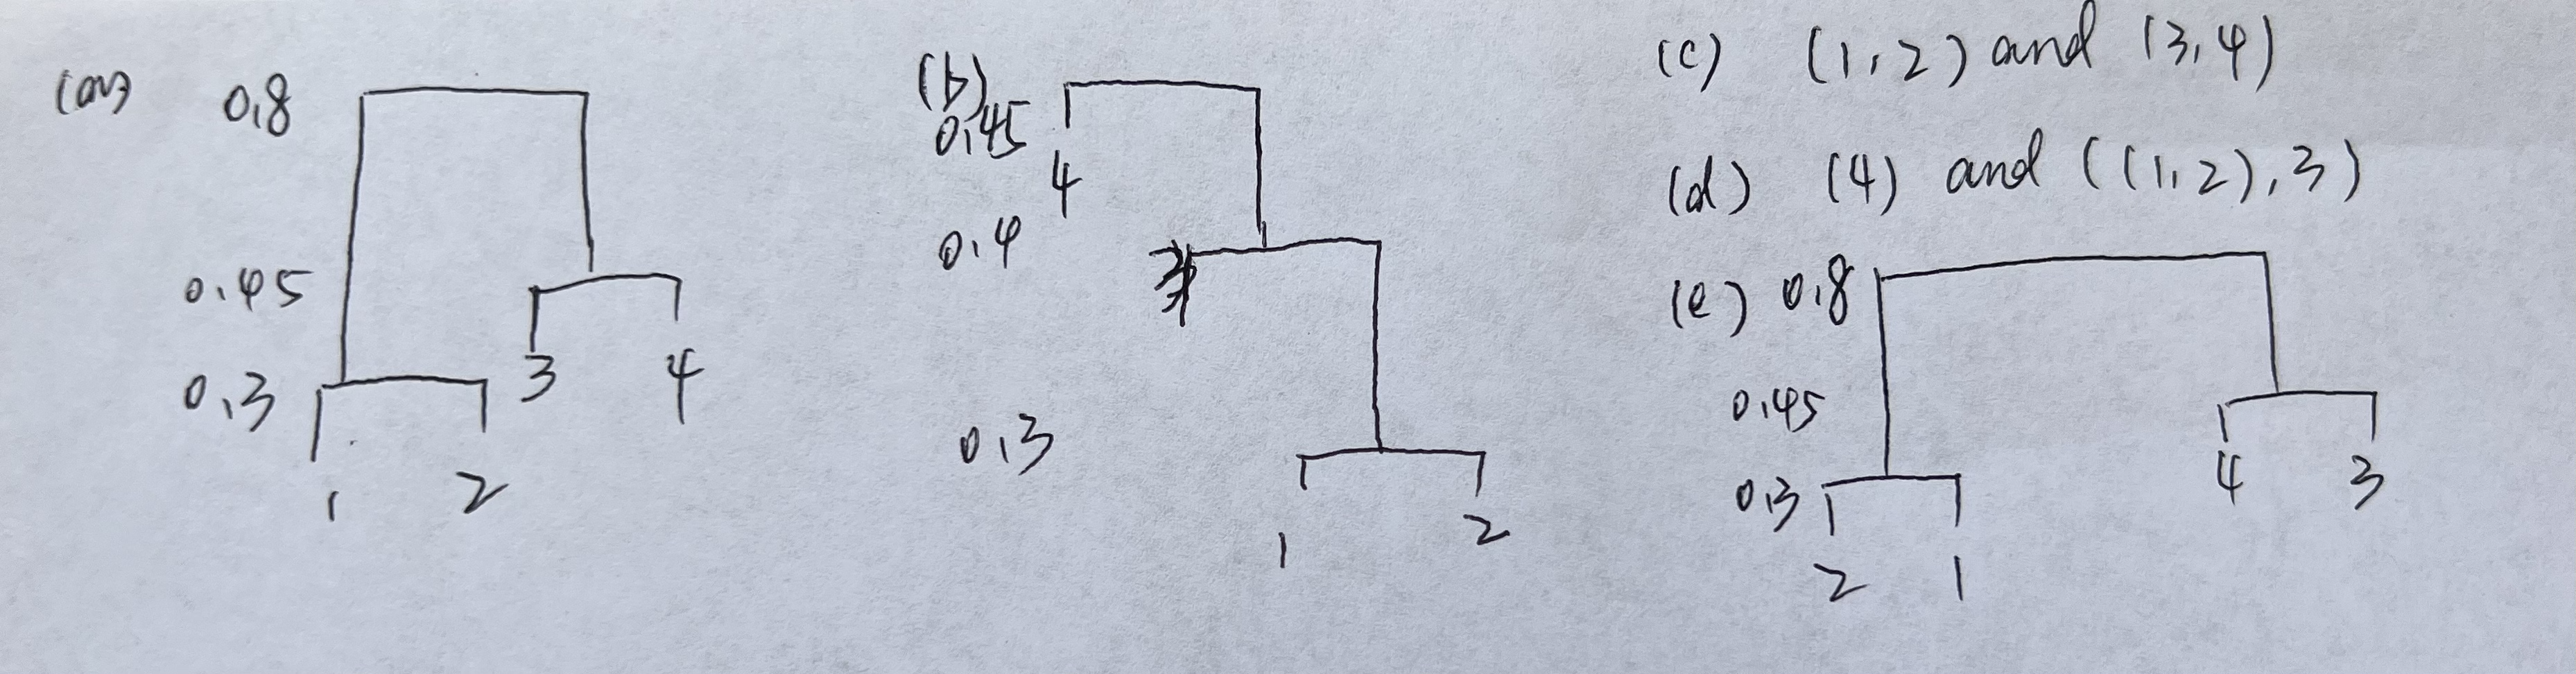